In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests

In [193]:
alz_df = pd.read_csv('mortality_cleaned_data.csv')
alz_df['alz_per_capita'] = (alz_df['alzheimer'] / alz_df['Pop2021']) * 100000

alz_df['week'] = pd.to_datetime(alz_df['week'], format='%Y-%m-%d')
alz_df['date_accessed'] = pd.to_datetime(alz_df['date_accessed'])
alz_df.head(5)

,Unnamed: 0,rank,State,Pop,Growth,Pop2021,Pop2010,growthSince2010,Percent,density,...,lower_resp_distress,other_resp,nephritis,nephrotic_synd_and_nephrosis,other,heart_disease,cerebrovasc_disease,covid_19_multiple_cause,Code,alz_per_capita
0,0,24.0,Alabama,4949697.0,0.0031,4934193.0,4785437.0,0.0343,0.0147,97.7332,...,86.0,13.0,25.0,25.0,268.0,81.0,0.0,0.0,AL,1.094404
1,1,24.0,Alabama,4949697.0,0.0031,4934193.0,4785437.0,0.0343,0.0147,97.7332,...,72.0,20.0,23.0,34.0,274.0,68.0,0.0,0.0,AL,0.830936
2,2,24.0,Alabama,4949697.0,0.0031,4934193.0,4785437.0,0.0343,0.0147,97.7332,...,73.0,21.0,23.0,24.0,239.0,45.0,0.0,0.0,AL,1.074137
3,3,24.0,Alabama,4949697.0,0.0031,4934193.0,4785437.0,0.0343,0.0147,97.7332,...,61.0,11.0,14.0,23.0,284.0,70.0,0.0,0.0,AL,1.094404
4,4,24.0,Alabama,4949697.0,0.0031,4934193.0,4785437.0,0.0343,0.0147,97.7332,...,76.0,17.0,20.0,23.0,265.0,55.0,0.0,0.0,AL,1.175471


In [194]:
# top 10 medians per capita by state

state_geo = f"https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json"
response = requests.get(state_geo)
geojson = response.json()

map_data = alz_df.groupby('Code', as_index = False)['alz_per_capita'].sum()

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=geojson,
    name="choropleth",
    data=map_data,
    columns=["Code", "alz_per_capita"],
    key_on="feature.id",
    fill_color="GnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Alzheimers Deaths (%)",
).add_to(m)

m

Text(0.5, 1.0, 'Highest Alzheimer Death Rates Per Capita By State')

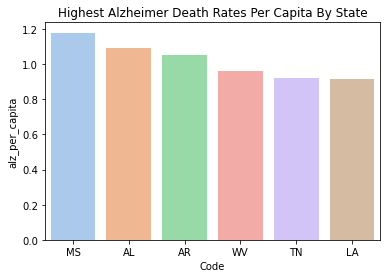

In [195]:
# top 10 max values per capita by state 
grouped_data = alz_df.groupby('Code')['alz_per_capita'].median().sort_values(ascending=False).reset_index()
largest_six = grouped_data.nlargest(6,'alz_per_capita')

ax = sns.barplot(x="Code", y="alz_per_capita", data=largest_six, palette='pastel')
ax.set_title('Highest Alzheimer Death Rates Per Capita By State')

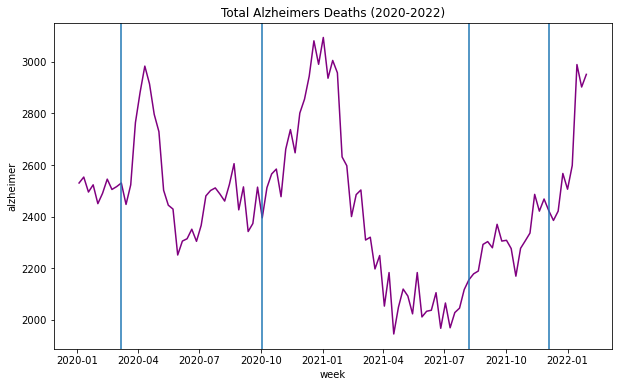

In [196]:
total_before_2022 = alz_df.loc[(alz_df['week'] < '2-01-2022')]
total_before_2022 = alz_df.groupby(total_before_2022['week'])['alzheimer'].sum()
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Total Alzheimers Deaths (2020-2022)')
sns.lineplot(data=total_before_2022, color='purple')

# plotting dates where COVID-19 spikes occurred by approximate month
ax.axvline(x=pd.to_datetime('2020-03-07'), ymin = 0)
ax.axvline(x=pd.to_datetime('2020-10-03'), ymin = 0)
ax.axvline(x=pd.to_datetime('2021-08-07'), ymin = 0)
ax.axvline(x=pd.to_datetime('2021-12-04'), ymin = 0)

plt.show()

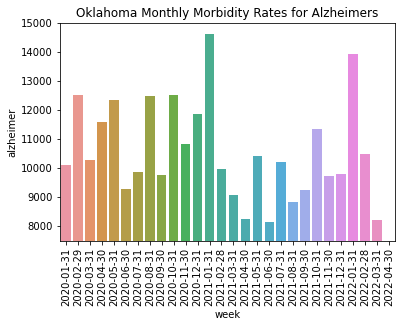

In [197]:
oklahoma = alz_df.loc[alz_df.Code == 'OK']
# left off with sum instead of individual rates for oklahoma
oklahoma_month = alz_df.resample(rule='M', on='week', convention='start')['alzheimer'].sum().reset_index()
oklahoma_month['week'] = oklahoma_month['week'].dt.date
ax = sns.barplot(x="week", y="alzheimer", data=oklahoma_month)

ax.set_title('Oklahoma Monthly Morbidity Rates for Alzheimers')

# scaled in to better visualize spikes in cases
plt.ylim(7500, 15000)
plt.xticks(rotation=90)

plt.show()

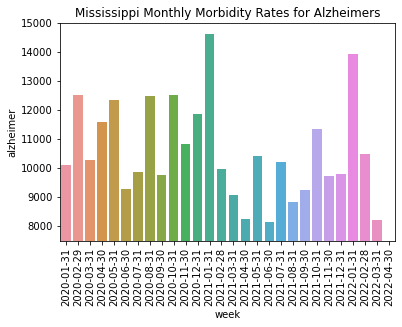

In [198]:
ms = alz_df.loc[alz_df.Code == 'MS']
ms_month = alz_df.resample(rule='M', on='week', convention='start')['alzheimer'].sum().reset_index()
ms_month['week'] = ms_month['week'].dt.date
ax = sns.barplot(x="week", y="alzheimer", data=oklahoma_month)

ax.set_title('Mississippi Monthly Morbidity Rates for Alzheimers')

# scaled in to better visualize spikes in cases
plt.ylim(7500, 15000)
plt.xticks(rotation=90)

plt.show()